### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [4]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

### Read the data frame from pickle file

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [6]:
#read data
filename=data_dir+'/US_Weather_BBBSBBBB.csv'
List=load(open(filename,'rb'))
print 'length of List=',len(List)

df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

length of List= 13047
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Read and process sample data

In [9]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00198301')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00198301'
26 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(26, 365)

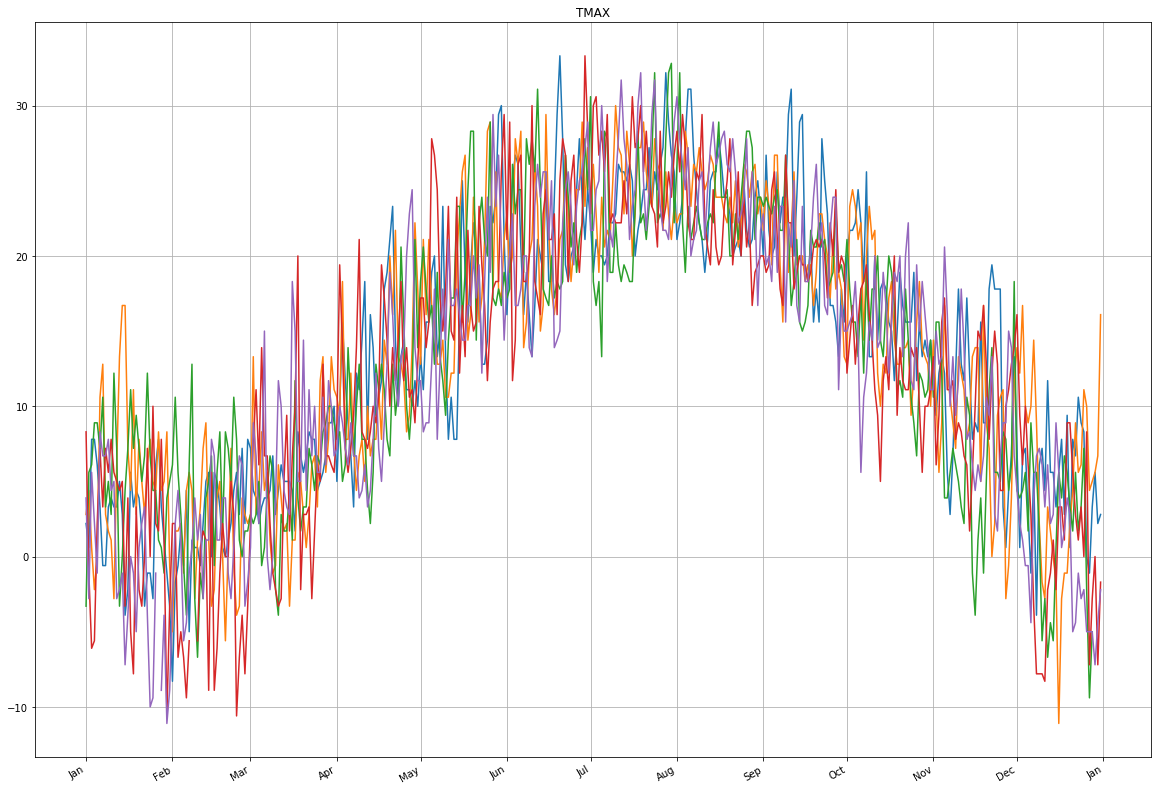

In [12]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(20,15));
YP=YearPlotter()
YP.plot(T[:5,:].transpose(),fig,ax,title='TMAX')


### Plot Reconstructions

From each measurement, we take 4 sample stations with low residual error and 4 sample stations with high residual error and plot the following:

* Original Data Vector
* Reconstructed Data Vector from top 1 eigen vectors
* Reconstructed Data Vector from top 2 eigen vectors
* Reconstructed Data Vector from top 3 eigen vectors

In [12]:
def create_reconstructions(m):  
    Prod={}
    for k in range(1,4):
        Eigen=np.matrix(Stats[0][m]['eigvec'][:,:k])
        matrix=np.matrix(m_df[m].ix[:,2:367])-Stats[0][m]['Mean']
        matrix[isnan(matrix)]=0
        Prod[k]=matrix*Eigen
    Reconstructed={}
    for k in range(1,4):
        Eigen=np.matrix(Stats[0][m]['eigvec'][:,:k])
        Reconstructed[k]=array(Eigen*Prod[k].transpose()+Stats[0][m]['Mean'][:,np.newaxis])
        
    original=np.array(m_df[m].ix[:,2:367])-Stats[0][m]['Mean']
    residue_list=[]
    for i in range(len(Reconstructed[1][0])):
        vec_diff=original[i]-Reconstructed[3][:,i]
        residue=np.linalg.norm(vec_diff)
        residue_list.append((residue,i))
    residue_list=[x for x in residue_list if not math.isnan(x[0])]
    residue_list=sorted(residue_list)
    
    lower=[i for (r,i) in residue_list[:4]]
    upper=[i for (r,i) in residue_list[-4:]]
    
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,9),dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)
    
    c=0
    for l in upper:
        subplot(2,4,j)
        j+=1
        c+=1
        plot(original[l])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','1','2','3'],loc=2)


Reconstruction Plots for TMIN
Reconstruction Plots for TOBS
Reconstruction Plots for TMAX
Reconstruction Plots for SNOW
Reconstruction Plots for SNWD
Reconstruction Plots for PRCP


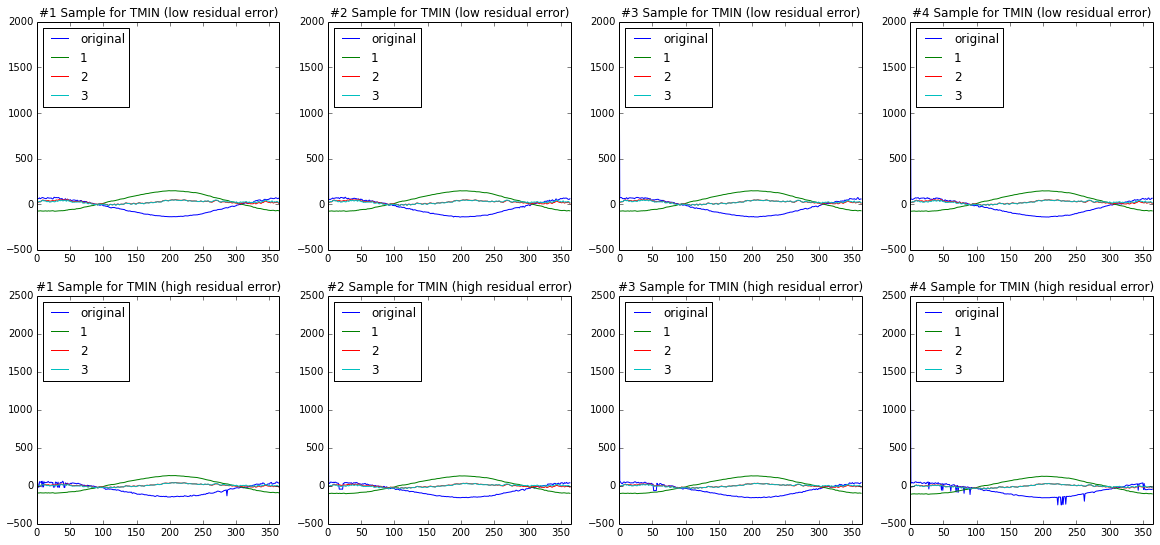

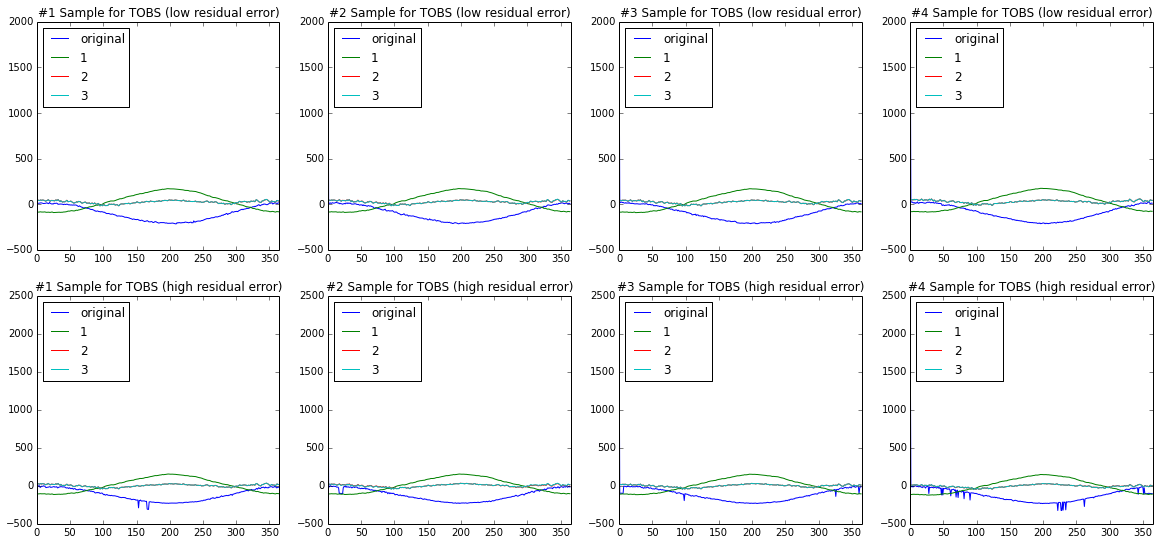

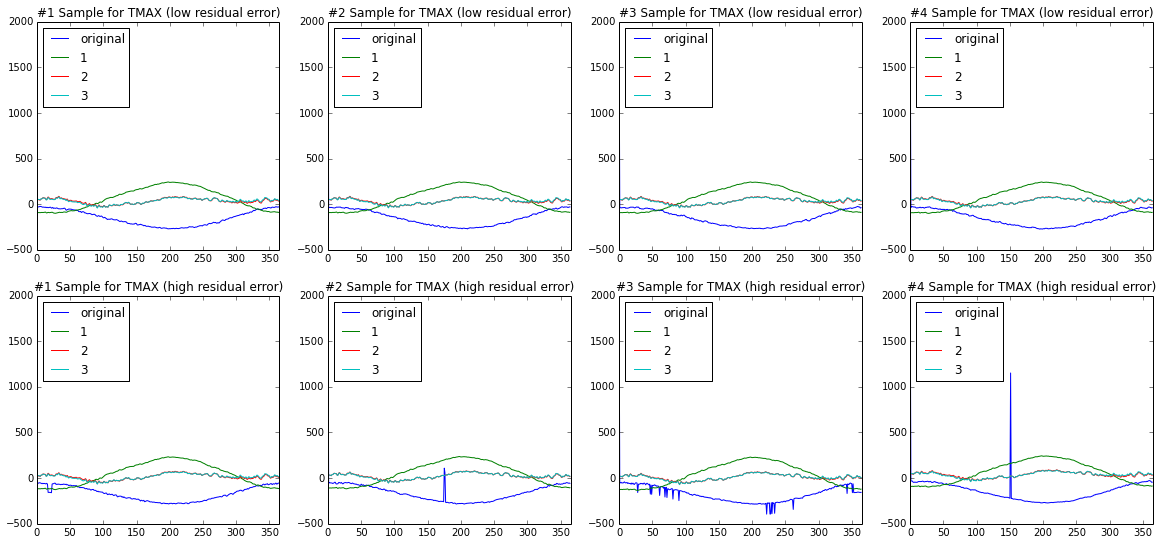

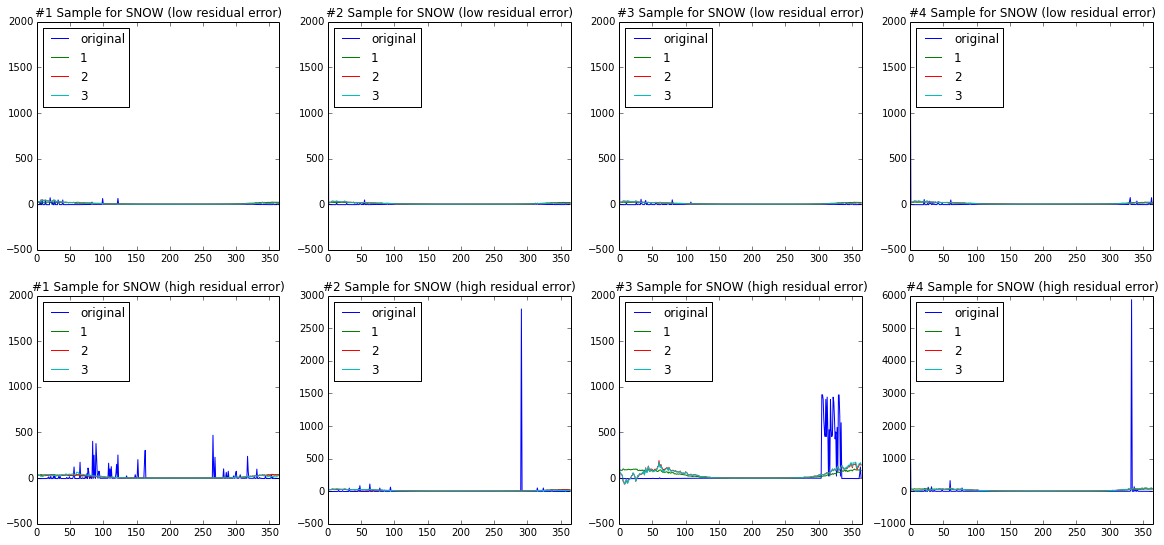

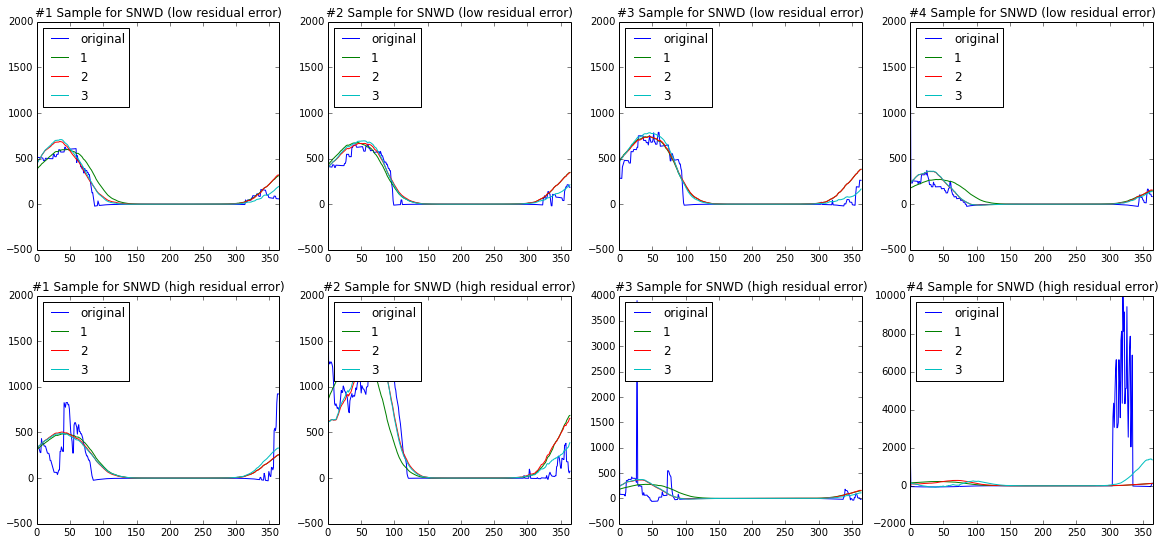

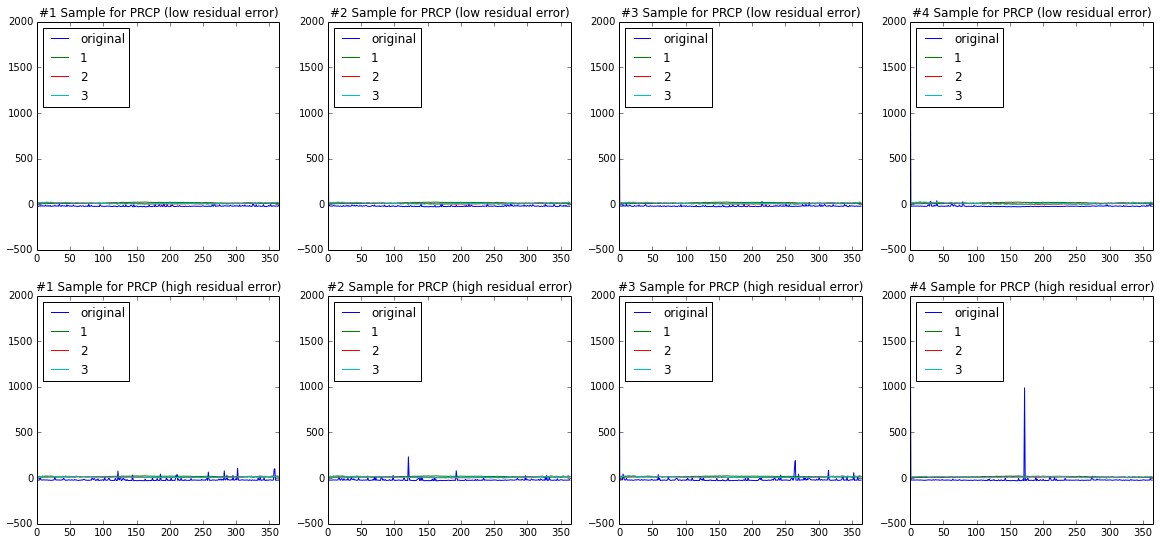

In [13]:
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)